## Road Network-Based EV Charging Station Placement and Supply Allocation

This notebook demonstrates a method for estimating traffic flow on **motorways** and **trunk roads** using OD (Origin-Destination) data and selecting appropriate charging station locations based on intersection points of these roads. The steps followed in this process are:

1. **Traffic Flow Estimation**: Using OD data, we calculate the traffic flow along various road segments, specifically focusing on **motorways** and **trunk roads**. This step ensures we accurately reflect demand for electric vehicle (EV) charging along heavily trafficked routes.

2. **Intersection Identification**: We identify the intersection points of motorways and trunk roads. These intersections represent potential locations where charging stations may be required to meet the demand of electric vehicles traveling through these routes.

3. **Charging Station Candidate Selection**: Once the intersection points are identified, an algorithm is employed to select appropriate candidate sites for EV charging stations. The algorithm takes into account factors like road connectivity and proximity to major traffic routes.

4. **Supply Distribution**: The supply of charging capacity is allocated to each station based on the estimated traffic flow in its vicinity. The idea is to ensure that the number of chargers at each location matches the demand generated by the vehicles using that road segment.

5. **Algorithm Overview**: The station selection and supply allocation follow an optimization approach that seeks to balance demand with the capacity of each station, ensuring an efficient distribution of resources across the road network.

This approach provides a structured way of placing EV charging stations across a road network, optimizing for the needs of electric vehicles based on real-world traffic patterns.

---
### IDEA: 
- Travelers traveling between urbans on highways may need to recharge urgently along their route. Therefore, electric vehicle charging stations on highways must be DCFC and located within 50 miles (regulations).

---
### Key Steps:
- **Step1. Traffic Flow Calculation**: Estimating traffic flow based on the OD matrix.
- **Step2. Intersection Analysis**: Identifying potential locations for charging stations based on road intersections.
- **Step3. Supply Allocation**: Allocating the appropriate number of chargers at each candidate location.

The following sections provide detailed code and explanations for each of these steps.

---

### Step 1. Traffic Flow Calculation: Estimating traffic flow based on the OD matrix.
This is a data processing process that calculates the amount of movement between cities using OD data. NHTS data has values ​​divided into weekends and weekdays, so these were combined.

#### Step 1.1 Calculating intercity movement volume through OD data processing

In [ ]:
import osmnx as ox
import folium
import geopandas as gpd
import networkx as nx
import pandas as pd
from shapely.geometry import Point, Polygon

In [ ]:
# Load CSV file
file_path = './data/new_OD/GDOT_2019_09.csv' ## NHTS OD data
df = pd.read_csv(file_path)

# Filter rows where 'origin_zone_id' and 'destination_zone_id' have a length of 12 characters
# 12-Length of id name is for Census Group Block 
df_filtered = df[df['origin_zone_id'].astype(str).str.len() == 12]
df_filtered = df_filtered[df_filtered['destination_zone_id'].astype(str).str.len() == 12]

# OD data distinguishes between weekends and weekdays, so we combine them.
df_grouped = df_filtered.groupby(['origin_zone_id', 'destination_zone_id']).agg({'mode_car': 'sum'}).reset_index()

#### Step 1.2. Extracting the shortest distance path between cities using highways

In [ ]:
# Load OSM network in Geourgia(from OSM network File)
osm_network_path = './data/osm_network.graphml'
G_main = ox.load_graphml(filepath=osm_network_path)
nodes, edges = ox.graph_to_gdfs(G_main)

# Calculate the centroid of the OSM network
center_point = ox.graph_to_gdfs(G_main, edges=False).unary_union.centroid

# Load urban area shapefile and city data
urban_path = './data/urban_Geourgia.gpkg' # urban boundary data from 'CENSUS'
df_city_grouped_sorted = df_grouped # Grouped by 'origin_zone_id' and 'destination_zone_id', then sum 'mode_car' values
urban_gdf = gpd.read_file(urban_path)
urban_gdf = urban_gdf.to_crs(epsg=4326)

In [ ]:
# Extract centroids of urban areas
urban_gdf['centroid'] = urban_gdf['geometry'].centroid

# Save each urban's polygon geometry in a dictionary
city_polygons = {row['NAME20']: row['geometry'] for idx, row in urban_gdf.iterrows()}

# Calculate the shortest paths and assign traffic to road links
edge_traffic = {}

def get_nearest_motorway_node_within_polygon(polygon, graph, buffer_dist=7000):
    """
    Find motorway or trunk nodes within a polygon.
    If not found, search within a buffer distance. Return None if not found.
    """
    # Find nodes within the polygon
    nodes_within_polygon = ox.graph_to_gdfs(graph, edges=False)[polygon.intersects(ox.graph_to_gdfs(graph, edges=False).geometry)]
    
    if not nodes_within_polygon.empty:
        return nodes_within_polygon.index[0]
    
    # Apply buffer if no nodes are found within the polygon
    buffered_polygon = polygon.buffer(buffer_dist)
    nodes_within_buffer = ox.graph_to_gdfs(graph, edges=False)[buffered_polygon.intersects(ox.graph_to_gdfs(graph, edges=False).geometry)]
    
    if not nodes_within_buffer.empty:
        return nodes_within_buffer.index[0]
    
    return None

for _, row in df_city_grouped_sorted.iterrows():
    origin_city = row['origin_city']
    destination_city = row['destination_city']
    mode_car = row['mode_car']
    
    # Skip if origin and destination cities are the same
    if origin_city == destination_city:
        print(f"Skipping same city pair: {origin_city}")
        continue
    
    if origin_city in city_polygons and destination_city in city_polygons:
        origin_polygon = city_polygons[origin_city]
        destination_polygon = city_polygons[destination_city]
        
        # Find motorway nodes within or near the city polygons (with 3km buffer)
        origin_node = get_nearest_motorway_node_within_polygon(origin_polygon, G_main)
        destination_node = get_nearest_motorway_node_within_polygon(destination_polygon, G_main)
        
        if origin_node is None or destination_node is None:
            print(f"No motorway/trunk node found within 3km buffer for {origin_city} or {destination_city}. Skipping this pair.")
            continue
        
        try:
            # Calculate the shortest path using only motorway and trunk roads
            motorway_path = nx.shortest_path(G_main, origin_node, destination_node, weight='length')

            # Print success message for each city pair
            print(f"Successfully calculated path between {origin_city} and {destination_city}")

            # Add traffic to the links along the path
            for u, v in zip(motorway_path[:-1], motorway_path[1:]):
                if (u, v) in edge_traffic:
                    edge_traffic[(u, v)] += mode_car
                else:
                    edge_traffic[(u, v)] = mode_car

        except (nx.NetworkXNoPath, nx.NodeNotFound):
            print(f"No motorway/trunk path found between {origin_city} and {destination_city}. Skipping this pair.")
            continue

#### Step 1-3. Mapping intercity movement volume to the corresponding highway path

In [ ]:
# Save the results to a GeoDataFrame
edge_list = []

for (u, v), traffic in edge_traffic.items():
    try:
        # Get geometry and assigned traffic for each link
        edge = edges.loc[(u, v)]
        edge_list.append({
            'u': u,
            'v': v,
            'geometry': edge.geometry,
            'traffic': traffic
        })
    except KeyError:
        print(f"Edge between {u} and {v} not found in edges dataframe. Skipping this entry.")
        continue

# Convert to a GeoDataFrame
edge_gdf = gpd.GeoDataFrame(edge_list, crs=edges.crs)

# Save the link's traffic result to a GeoPackage file
output_path = './data/network_traffic.gpkg'
edge_gdf.to_file(output_path, driver='GPKG')

print(f"Results saved to {output_path}.")
edge_gdf

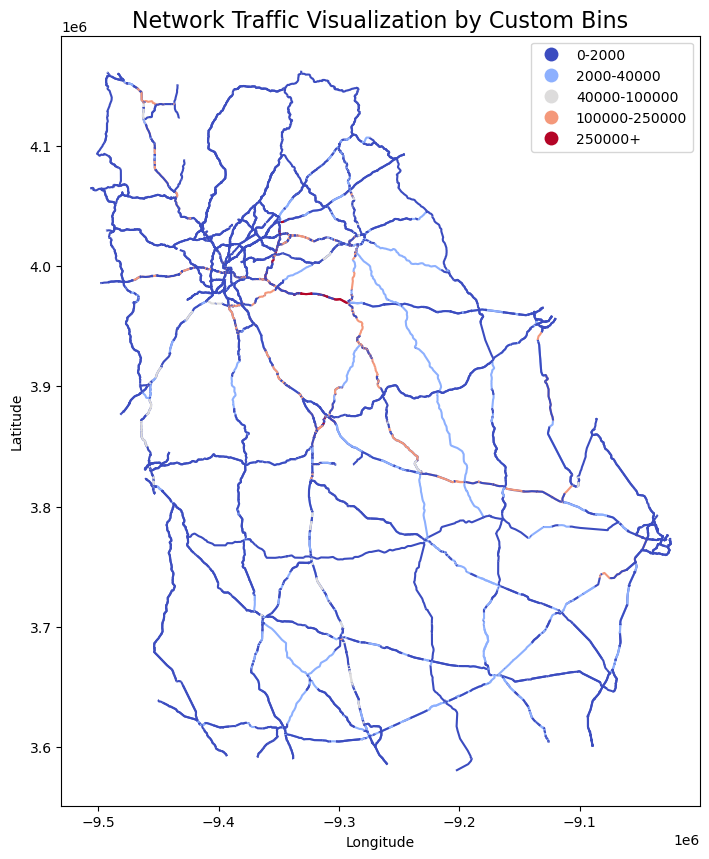

In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# For visualization
bins = [0, 2000, 40000, 100000, 250000, float('inf')]
labels = ['0-2000', '2000-40000', '40000-100000', '100000-250000', '250000+']
edge_gdf['traffic_bin'] = pd.cut(edge_gdf['traffic'], bins=bins, labels=labels, include_lowest=True)

fig, ax = plt.subplots(figsize=(10, 10))
edge_gdf.plot(column='traffic_bin', ax=ax, legend=True, cmap='coolwarm', categorical=True)

ax.set_title('Network Traffic Visualization', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

### Step 2. Intersection Analysis: Identifying potential locations for charging stations based on road intersections.
In this section, we find the optimal location of electric vehicle charging stations within the radius of highway intersections. Since highways consider through traffic, it is suitable to be located within 1.5 miles of an intersection. Among these, we prioritize based on the 'Category' of OSM data and find suitable POIs accordingly, and among the POIs with the highest scores, we find the POI that is most easily accessible from the intersection.

In [1]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points

In [ ]:
# Load data
intersections = gpd.read_file('./intersection.shp') # Make a intersection points with Motorway & Trunk roads using QGIS
osm_poi = gpd.read_file('./osm_poi_filtered.gpkg') # OSM POI
sig_poi = gpd.read_file('./POI.shp') # GISCUP2024 GIVEN
road_network = gpd.read_file('./data/network_traffic.gpkg') #Traffic volume per road network calculated in the above process

# Project all data to the same CRS (EPSG:3857)
intersections = intersections.to_crs(epsg=3857)
osm_poi = osm_poi.to_crs(epsg=3857)
sig_poi = sig_poi.to_crs(epsg=3857)
road_network_projected = road_network.to_crs(epsg=3857)

In [ ]:
# For the passengers, the charging station on the highway should be within a 1.5 mile radius of the crossing. (1.5 miles = 2414.02 meters)
def buffer_intersection(intersection_point, distance=2414.02):
    return intersection_point.buffer(distance)

# Select the optimal charging station location at the intersection based on the score and distance by category.
def select_best_poi(poi_gdf, buffer, scoring_dict):
    # Filter POIs within the buffer
    pois_in_buffer = poi_gdf[poi_gdf.intersects(buffer)]
    
    # If no OSM POIs are found within the buffer, return None
    if pois_in_buffer.empty:
        return None
    
    # Apply scoring based on fclass and sort by score and distance
    pois_in_buffer['score'] = pois_in_buffer['fclass'].map(scoring_dict)
    pois_in_buffer = pois_in_buffer.dropna(subset=['score'])
    
    # If there are no valid POIs after applying the scoring, return None
    if pois_in_buffer.empty:
        return None
    
    pois_in_buffer['distance'] = pois_in_buffer.geometry.distance(buffer.centroid)
    
    # Sort first by score (descending) and then by distance (ascending)
    pois_in_buffer = pois_in_buffer.sort_values(by=['score', 'distance'], ascending=[False, True])
    
    # Return the best POI (highest score and closest)
    return pois_in_buffer.iloc[0] if len(pois_in_buffer) > 0 else None

# Function to select POI from alternative data based on distance
def select_alternative_poi(osm_poi, buffer, categories):
    # Filter POIs within the buffer and category
    pois_in_buffer = osm_poi[osm_poi.intersects(buffer) & osm_poi['Category'].isin(categories)]
    
    # If no POIs are found within the buffer, return None
    if pois_in_buffer.empty:
        return None
    
    pois_in_buffer['distance'] = pois_in_buffer.geometry.distance(buffer.centroid)
    pois_in_buffer = pois_in_buffer.sort_values(by='distance')
    
    return pois_in_buffer.iloc[0] if len(pois_in_buffer) > 0 else None

In [ ]:
# Define scoring for filtered.gpkg POIs based on fclass, mannually
# The POI of OSM is prioritized.
osm_score = {
    'hotel': 3, 'department_store': 3, 'supermarket': 3, 'town_hall': 3, 'museum': 3, 
    'library': 3, 'convenience': 3, 'restaurant': 3, 'hospital': 3, 'sports_centre': 3, 

    'monument': 3, 'attraction': 3, 'fast_food': 3, 'clothes': 2, 'florist': 2, 
    'nursing_home': 2, 'post_office': 2, 'pharmacy': 2, 'fire_station': 2, 
    'camp_site': 2, 'courthouse': 2, 'dentist': 2, 'bank': 2, 
    'motel': 2, 'community_centre': 2
}

# If there is no OSM POI within the radius, use other POI data.
alternative_categories = ['farmers_market', 'convenience_store', 'butcher_shop', 'gas_station', 'travel_services']

### Step3. Supply Allocation: Allocating the appropriate number of chargers at each candidate location.
Set the capacity of electric vehicle charging stations on the highway based on the traffic volume on the highway. 
The stages are divided into three stages, and the capacity for each stage is specified. The division according to this is based on California highway charging stations.

In [ ]:
# Initialize list to store final POIs
selected_pois = []

def assign_supply_based_on_traffic(poi, road_network):
    nearest_road_geom = nearest_points(poi.geometry, road_network.unary_union)[1]
    nearest_road = road_network[road_network.geometry == nearest_road_geom]
    
    if nearest_road.empty:
        return None
    
    traffic = nearest_road['traffic'].values[0]
    
    if traffic <= 1016:
        return 2
    elif traffic <= 8967:
        return 4
    else:
        return 8p
    
# Loop over intersections and process
for _, intersection in intersections.iterrows():
    buffer = buffer_intersection(intersection.geometry)
    
    # Try selecting from filtered.gpkg
    selected_poi = select_best_poi(osm_poi, buffer, osm_score)
    
    # If no POI selected, try from POI.shp
    if selected_poi is None:
        selected_poi = select_alternative_poi(sig_poi, buffer, alternative_categories)
    
    if selected_poi is not None:
        supply_value = assign_supply_based_on_traffic(selected_poi, road_network_projected)
        selected_pois.append({
            'id': f"poi_{len(selected_pois) + 1}",
            'geometry': selected_poi.geometry,  # Ensure geometry is added correctly
            'fclass': selected_poi.get('fclass', None),
            'Category': selected_poi.get('Category', None),
            'supply': supply_value  # Add the calculated supply based on traffic
        })

# Make sure geometry is present in the list and create GeoDataFrame
if len(selected_pois) > 0:
    gdf_selected_pois = gpd.GeoDataFrame(selected_pois, geometry='geometry', crs=intersections.crs)
    
    # Save the result to a new file
    gdf_selected_pois.to_file('./selected_charging_station_Highway.gpkg', driver='GPKG')
else:
    print("No POIs were selected.")

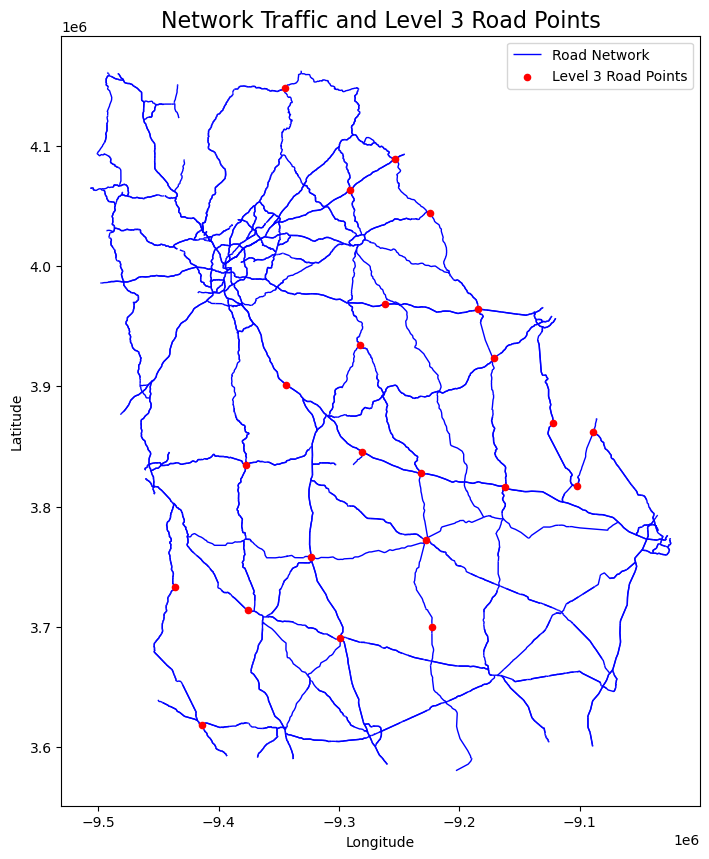

In [29]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Visualization
fig, ax = plt.subplots(figsize=(10, 10))
edge_gdf.plot(ax=ax, color='blue', linewidth=1, label='Road Network')
gdf_selected_pois.plot(ax=ax, color='red', marker='o', markersize=20, label='Level 3 Road Points', zorder=10)

ax.set_title('DCFC position on Highway', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.show()